In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import time
import nibabel as nib
import ctvis
from glob import glob
from pathlib import Path
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

In [2]:
# DataFrameを作成　（script file からの読み込み） / ctvis.get_df_all()
ctvis.get_df_all('../public-covid-data')

,FilePathImage,FileName,FilePathMask
0,../public-covid-data/rp_im/1.nii.gz,1.nii.gz,../public-covid-data/rp_msk/1.nii.gz
1,../public-covid-data/rp_im/2.nii.gz,2.nii.gz,../public-covid-data/rp_msk/2.nii.gz
2,../public-covid-data/rp_im/3.nii.gz,3.nii.gz,../public-covid-data/rp_msk/3.nii.gz
3,../public-covid-data/rp_im/4.nii.gz,4.nii.gz,../public-covid-data/rp_msk/4.nii.gz
4,../public-covid-data/rp_im/5.nii.gz,5.nii.gz,../public-covid-data/rp_msk/5.nii.gz
5,../public-covid-data/rp_im/6.nii.gz,6.nii.gz,../public-covid-data/rp_msk/6.nii.gz
6,../public-covid-data/rp_im/7.nii.gz,7.nii.gz,../public-covid-data/rp_msk/7.nii.gz
7,../public-covid-data/rp_im/8.nii.gz,8.nii.gz,../public-covid-data/rp_msk/8.nii.gz
8,../public-covid-data/rp_im/9.nii.gz,9.nii.gz,../public-covid-data/rp_msk/9.nii.gz


In [3]:
df = ctvis.get_df_all('../public-covid-data')

([], <a list of 0 Text yticklabel objects>)

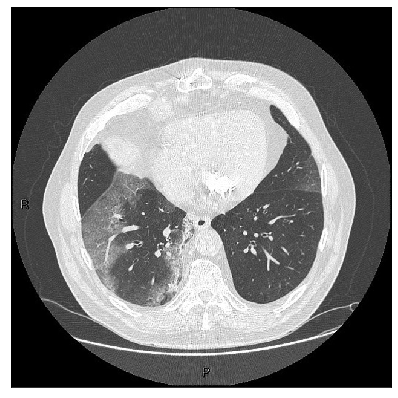

In [4]:
# NifTI データを NumPy Array としてロードする　（script file からの読み込み） / ctvis.load_nifti()
sample_path = df['FilePathImage'].iloc[0]
data = ctvis.load_nifti(sample_path)
plt.figure(figsize=(7, 7))
plt.imshow(data[:, :, 30], cmap='gray')
plt.xticks(ticks=[])
plt.yticks(ticks=[])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


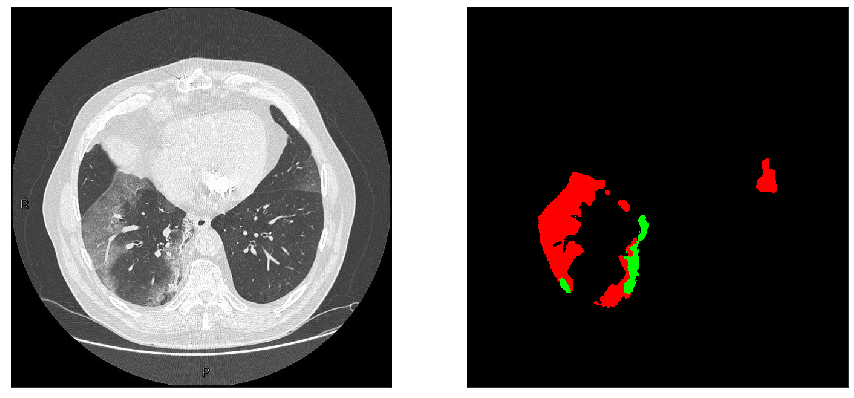

In [5]:
# Mask Data RGB 変換(algorithm) （script file からの読み込み） / ctvis.label_color()
p = df['FilePathMask'].iloc[0]
seg_data = ctvis.load_nifti(p)
mask_color = ctvis.label_color(seg_data)

# HUをgrayに変換する （script file からの読み込み） / ctvis.hu_to_gray()
index = 0
volume = ctvis.load_nifti(df.iloc[index]['FilePathImage'])
mask = ctvis.load_nifti(df.iloc[index]['FilePathMask'])
mask_color = ctvis.label_color(mask)
volume_gray = ctvis.hu_to_gray(volume)

data = [volume_gray[:, :, 30], mask_color[:, :, 30]]
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
for idx, i in enumerate(data):
    axes[idx].imshow(i, cmap='gray')
    axes[idx].set_xticks(ticks=[])  # 横軸のメモリを消す
    axes[idx].set_yticks(ticks=[])  # 縦軸のメモリを消す

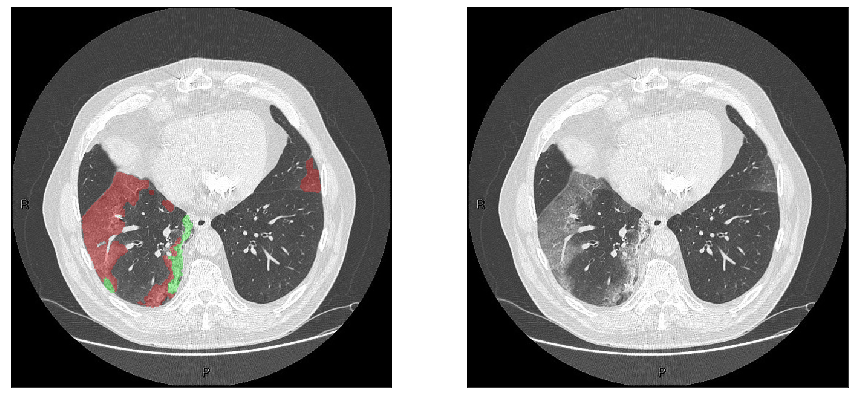

In [6]:
# Overlay(CTとアノテーションの重ね合わせ) : （script file からの読み込み） / overlay()
overlayed = ctvis.overlay(volume_gray, mask, mask_color, alpha=0.3)
data = [overlayed[:, :, 30], volume_gray[:, :, 30]]
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
for idx, i in enumerate(data):
    axes[idx].imshow(i, cmap='gray')
    axes[idx].set_xticks(ticks=[])  # 横軸のメモリを消す
    axes[idx].set_yticks(ticks=[])  # 縦軸のメモリを消す

## <u>COVID-19</u>
- *アノテーションマスク*
    - **青　:　ground-glass ( mask valu = 1 )**
        - すりガラスみたいに少し白いモヤが罹った場所が病変箇所
        - 本来空気が入っている場所だが、少し液状化が進んでいる
    - **黄　:　consolidation ( = 2 )**
        - もっと水に浸って白くなっている状態
    - **緑　:　pleural effusion ( = 3 )**
        - pleural effusion( 胸水 )
        - 胸水　:　肺の膜と肺が入っている壁の間に水が溜まっている状態


- CT では　-1000が空気なので　＝　黒, 空気よりx線を通してない事になる

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


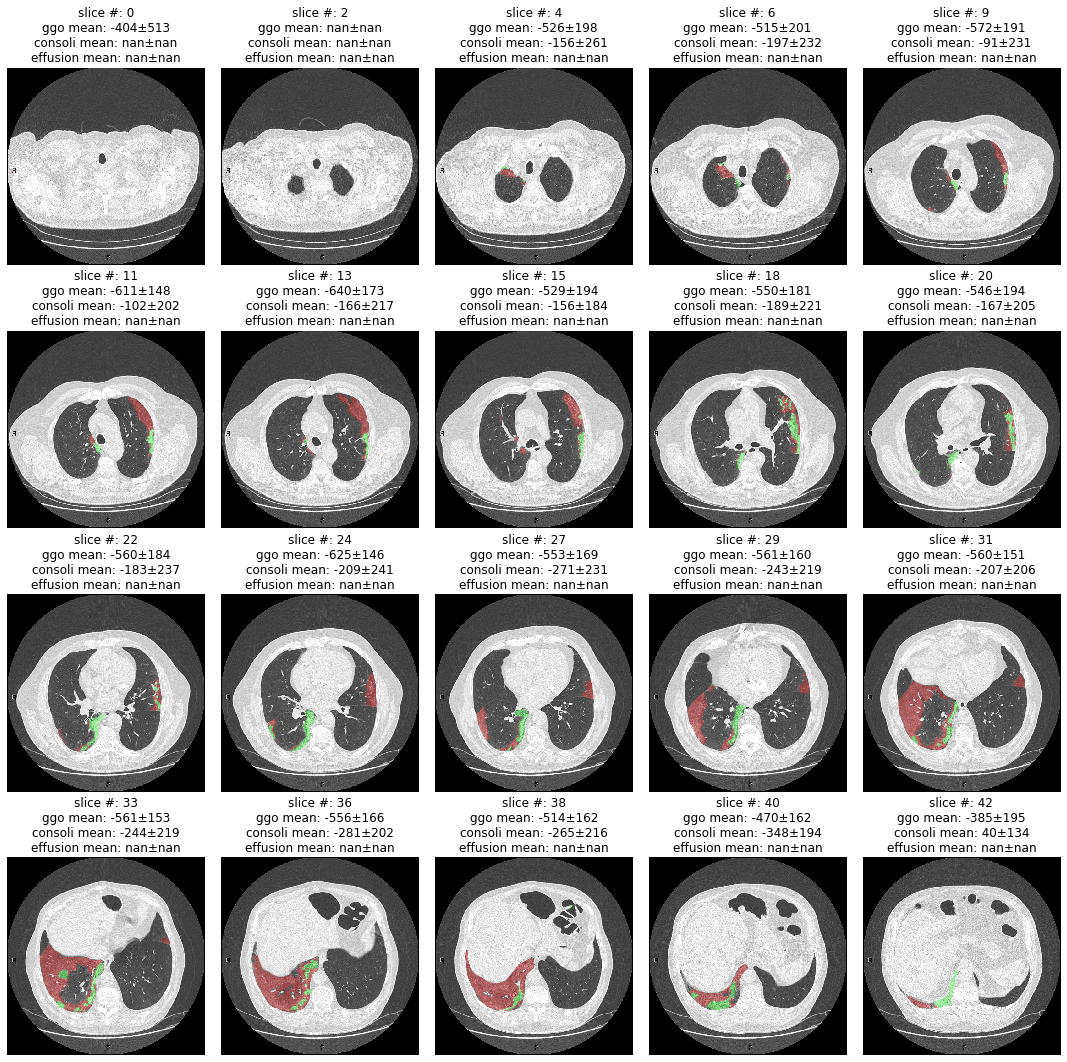

In [7]:
# slice label : slice番号(index)を表示, 各labelのHUの統計量を表示 （script file からの読み込み） / vis_overlay() : _get_hu_stats
ctvis.vis_overlay(overlayed, volume, mask, cols=5, display_num=20)

## HU window を設定する
#### 余計な数値を省く　＝　clip　＝　値を指定する
- <u>CT 画像を見る時は興味のある値は限られている</u>
    - *肺　:　HU　-900 ~ -100　で　clip*
        - **上記の値の範囲しか興味がない**
        - **肺を見る時に骨の白さなどはほとんど関係がない**
        - **使用目的によって数値を変える**


- <u>CT 画像は興味のある値　（range）　にだけフォーカスして表示させる</u>
    - *興味のある（見たいところ）組織だけをしっかりと確認することができる*
        - **興味のある値の範囲で　0 ~ 255 の値を当てはめる**
        - **肺　:　HU　-900 ~ -100　で　clip　->　0 ~ 255 の値に変換**


- <u>上記の　range　の事を　**HU Window**　という</u>
    - *肺　:　HU　-900 ~ -100　で　clip*
        - **min　=　-900**
        - **max　=　-100**
        - **np.clip と同じ処理をする**

In [8]:
# HU window clip : 肺　:　HU　-900 ~ -100　で　clip /min　=　-900/max　=　-100/
volume_clip = np.clip(volume, -900, 100) 
volume_clip = ctvis.hu_to_gray(volume_clip)

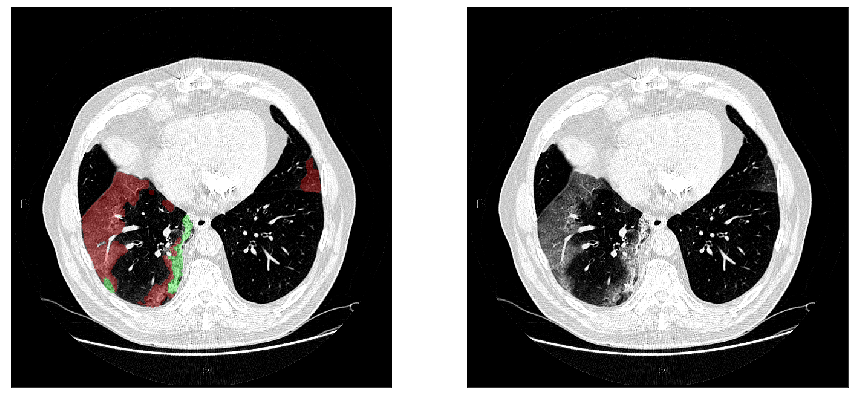

In [9]:
# Overlay(CTとアノテーションの重ね合わせ) : （script file からの読み込み） / overlay()
overlayed = ctvis.overlay(volume_clip, mask, mask_color, alpha=0.3)
data = [overlayed[:, :, 30], volume_clip[:, :, 30]]
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
for idx, i in enumerate(data):
    axes[idx].imshow(i, cmap='gray')
    axes[idx].set_xticks(ticks=[])  # 横軸のメモリを消す
    axes[idx].set_yticks(ticks=[])  # 縦軸のメモリを消す

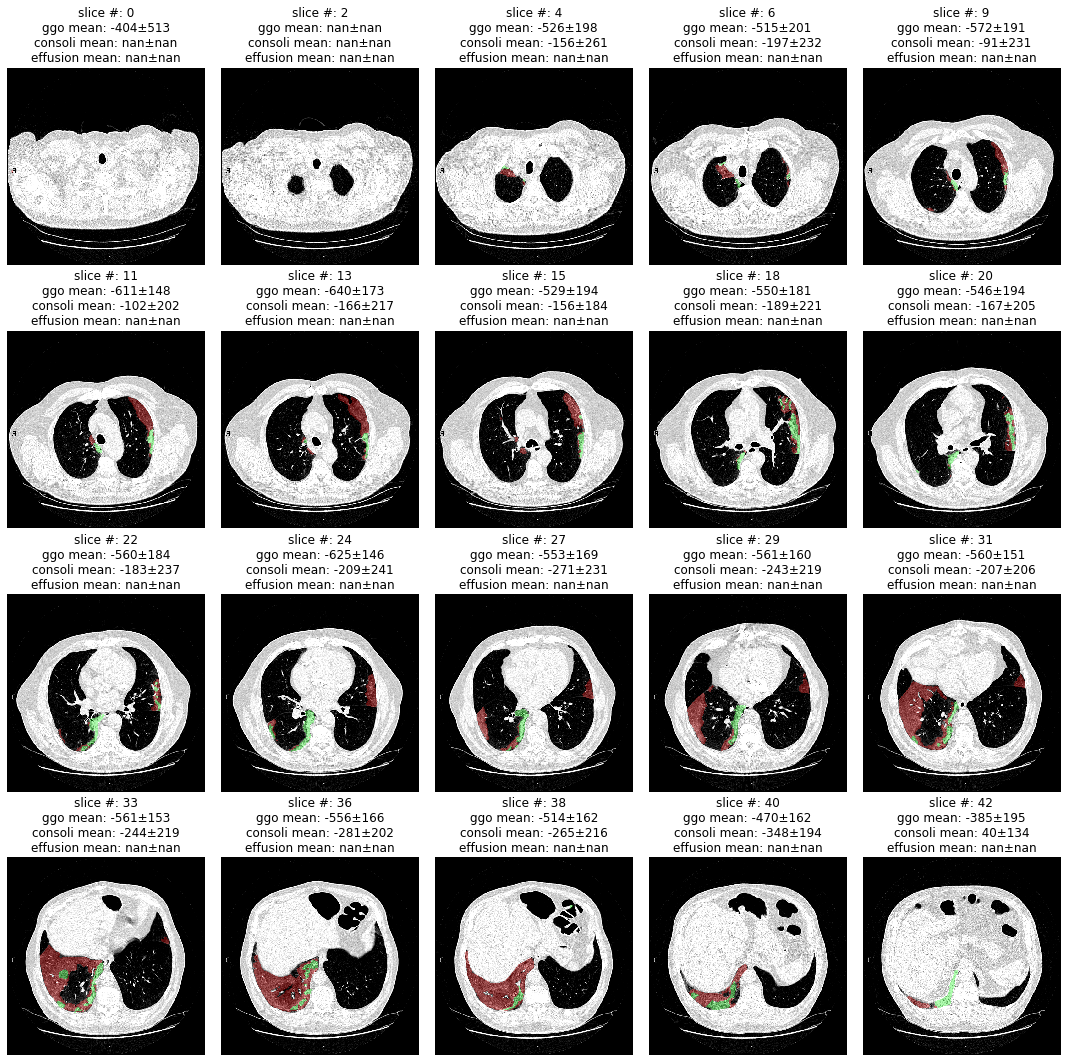

In [10]:
# slice label : slice番号(index)を表示, 各labelのHUの統計量を表示 （script file からの読み込み） / vis_overlay() : _get_hu_stats
ctvis.vis_overlay(overlayed, volume, mask, cols=5, display_num=20)